In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
import tensorflow as tf


In [2]:
# Load dataset
data = pd.read_csv('cuaca_data_regresi.csv', parse_dates=['time'])
data.set_index('time', inplace=True)

# Function to scale data
def preprocess_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Preprocess dataset
scaled_data, scaler = preprocess_data(data)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30104 entries, 2004-01-01 00:00:00 to 2024-08-08 18:00:00
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   temperature_2m (°C)        30104 non-null  float64
 1   relative_humidity_2m (%)   30104 non-null  int64  
 2   apparent_temperature (°C)  30104 non-null  float64
 3   rain (mm)                  30104 non-null  float64
 4   cloud_cover (%)            30104 non-null  int64  
 5   wind_speed_10m (km/h)      30104 non-null  float64
 6   wind_direction_10m (°)     30104 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 1.8 MB


In [4]:
# Function to prepare sequences for LSTM
def create_single_step_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


seq_length = 1


X, y = create_single_step_sequences(scaled_data, seq_length)


split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [5]:
# Build LSTM model for single-step prediction
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(y_train.shape[1], activation='relu')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the model
model.save('model_lstm_weather_prediction.h5')


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1357 - val_loss: 0.1236
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1119 - val_loss: 0.1226
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1075 - val_loss: 0.1096
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1010 - val_loss: 0.1081
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1006 - val_loss: 0.1079
Epoch 6/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0721 - val_loss: 0.0205
Epoch 7/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0193 - val_loss: 0.0207
Epoch 8/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0187 - val_loss: 0.0206
Epoch 9/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0188 - val_loss: 0.0216
Epoch 10/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0188 - val_loss: 0.0214
Epoch 11/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0188 - val_loss: 0.0205
Epoch 12/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.

In [12]:
import tensorflow as tf

# Load the .h5 model
model = tf.keras.models.load_model('model_lstm_weather_prediction.h5')

# Convert to TFLite
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable optimizations to minimize file size while maintaining performance
tflite_converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Specify supported operations for LSTM layers
tflite_converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Built-in TensorFlow Lite Ops
    tf.lite.OpsSet.SELECT_TF_OPS     # TensorFlow Ops for advanced layers
]

# Ensure the LSTM layers retain resource variable handling
tflite_converter.experimental_enable_resource_variables = True

# Convert the model
tflite_model = tflite_converter.convert()

# Save the .tflite model
with open("model_lstm_weather_prediction(REVISI).tflite", "wb") as f:
    f.write(tflite_model)

print("Model successfully converted and saved as 'model_lstm_weather_prediction(REVISI).tflite'.")


Saved artifact at '/tmp/tmpghkuvnbe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132639928310544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639928022848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639928317936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639928295216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639928295568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639928297328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639928298912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639928298384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639926600800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639926600272: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model successfully conve

In [11]:
import tensorflow as tf
#store .h5 file in your .py folder

#load h5 module
model=tf.keras.models.load_model('model_lstm_weather_prediction.h5')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable resource variables for better compatibility
tflite_converter.experimental_enable_resource_variables = True

# Set the supported ops to include SELECT_TF_OPS for LSTM compatibility
tflite_converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]

# Disable experimental lowering of tensor list ops
tflite_converter._experimental_lower_tensor_list_ops = False

#convert
tflite_model = tflite_converter.convert()
open("model_lstm_weather_prediction(REVISI).tflite", "wb").write(tflite_model)

#done convertion

Saved artifact at '/tmp/tmpkpfc22v3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132639929512560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639929500240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639929513088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639929612096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639929613856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639929613504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639929536000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639929535472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639929541632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132639929542512: TensorSpec(shape=(), dtype=tf.resource, name=None)


317804

In [6]:
import json

# Simpan parameter scaler
scaler_params = {
    "min": scaler.data_min_.tolist(),
    "max": scaler.data_max_.tolist(),
    "feature_range": scaler.feature_range
}

with open("scaler_params.json", "w") as json_file:
    json.dump(scaler_params, json_file)

print("Scaler berhasil disimpan dalam file JSON.")


Scaler berhasil disimpan dalam file JSON.


In [7]:
# Load the saved model
model = load_model('model_lstm_weather_prediction.h5')

# Example user input weather data
user_input_weather = {
    "temperature_2m (°C)": 26.3,
    "relative_humidity_2m (%)": 91,
    "apparent_temperature (°C)": 31.5,
    "rain (mm)": 0.0,
    "cloud_cover (%)": 100,
    "wind_speed_10m (km/h)": 9.4,
    "wind_direction_10m (°)": 94
}

# Function to scale the user input
def scale_user_input(user_input, scaler, data_columns):
    input_df = pd.DataFrame([user_input])[data_columns]
    scaled_input = scaler.transform(input_df)
    return scaled_input

# Prepare the scaled input
data_columns = list(data.columns)  # Ensure column order matches dataset
scaled_user_input = scale_user_input(user_input_weather, scaler, data_columns)

# Make it a sequence (pad to match sequence length)
padded_sequence = np.zeros((seq_length, len(data_columns)))  # Initialize empty sequence
padded_sequence[-1, :] = scaled_user_input  # Add the user input at the last time step
padded_sequence = np.expand_dims(padded_sequence, axis=0)  # Reshape for LSTM input

# Predict using the model
prediction_scaled = model.predict(padded_sequence)

# Reverse scaling for the prediction
predicted_weather = scaler.inverse_transform(prediction_scaled)[0]

# Display predicted weather
predicted_result = dict(zip(data_columns, predicted_weather))
print("Predicted weather 6 hours ahead:")
print(predicted_result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
Predicted weather 6 hours ahead:
{'temperature_2m (°C)': 25.778072, 'relative_humidity_2m (%)': 89.332695, 'apparent_temperature (°C)': 30.723717, 'rain (mm)': 0.0, 'cloud_cover (%)': 85.2355, 'wind_speed_10m (km/h)': 8.215472, 'wind_direction_10m (°)': 96.077255}


In [8]:
# Load the saved model
model = load_model('model_lstm_weather_prediction.h5')

# Example user input weather data
user_input_weather = {
    "temperature_2m (°C)": 25.778072,
    "relative_humidity_2m (%)": 89.332695,
    "apparent_temperature (°C)": 30.723717,
    "rain (mm)": 0.0,
    "cloud_cover (%)": 85.2355,
    "wind_speed_10m (km/h)": 8.215472,
    "wind_direction_10m (°)": 96.077255
}

# Function to scale the user input
def scale_user_input(user_input, scaler, data_columns):
    input_df = pd.DataFrame([user_input])[data_columns]
    scaled_input = scaler.transform(input_df)
    return scaled_input

# Prepare the scaled input
data_columns = list(data.columns)  # Ensure column order matches dataset
scaled_user_input = scale_user_input(user_input_weather, scaler, data_columns)

# Make it a sequence (pad to match sequence length)
padded_sequence = np.zeros((seq_length, len(data_columns)))  # Initialize empty sequence
padded_sequence[-1, :] = scaled_user_input  # Add the user input at the last time step
padded_sequence = np.expand_dims(padded_sequence, axis=0)  # Reshape for LSTM input

# Predict using the model
prediction_scaled = model.predict(padded_sequence)

# Reverse scaling for the prediction
predicted_weather = scaler.inverse_transform(prediction_scaled)[0]

# Display predicted weather
predicted_result = dict(zip(data_columns, predicted_weather))
print("Predicted weather 6 hours ahead:")
print(predicted_result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
Predicted weather 6 hours ahead:
{'temperature_2m (°C)': 26.039263, 'relative_humidity_2m (%)': 85.143425, 'apparent_temperature (°C)': 30.59715, 'rain (mm)': 0.0, 'cloud_cover (%)': 73.66799, 'wind_speed_10m (km/h)': 8.424507, 'wind_direction_10m (°)': 99.780525}


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the .tflite model
interpreter = tf.lite.Interpreter(model_path="weather_prediction.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Raw input data
raw_input_data = np.array([[26.6, 91, 32.9, 0.0, 96, 3.6, 270]], dtype=np.float32)

# Simulate dataset columns for scaling consistency
data_columns = [
    "temperature_2m (°C)",
    "relative_humidity_2m (%)",
    "apparent_temperature (°C)",
    "rain (mm)",
    "cloud_cover (%)",
    "wind_speed_10m (km/h)",
    "wind_direction_10m (°)"
]

# Load dataset and fit scaler
from pandas import read_csv
training_data = read_csv("cuaca_data_regresi.csv")[data_columns]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(training_data)

# Scale raw input data
scaled_input_data = scaler.transform(raw_input_data)

# Add sequence length dimension (sequence length = 1)
scaled_input_data = np.expand_dims(scaled_input_data, axis=1).astype(np.float32)

# Set the input tensor for inference
interpreter.set_tensor(input_details[0]['index'], scaled_input_data)

# Run inference
interpreter.invoke()

# Get the output tensor and reverse scale
prediction_scaled = interpreter.get_tensor(output_details[0]['index'])
predicted_weather = scaler.inverse_transform(prediction_scaled)[0]

# Map the predicted values to column names
predicted_result = dict(zip(data_columns, predicted_weather))

# Display the predicted weather
print("Predicted weather 6 hours ahead:")
print(predicted_result)


Predicted weather 6 hours ahead:
{'temperature_2m (°C)': 26.106104, 'relative_humidity_2m (%)': 90.997574, 'apparent_temperature (°C)': 31.316368, 'rain (mm)': 45.96852, 'cloud_cover (%)': 3.8965127, 'wind_speed_10m (km/h)': 30.233658, 'wind_direction_10m (°)': 3.0000002}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Reverse scaling to get original values
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Evaluation Metrics:
RMSE: 29.99
MAE: 15.79
R² Score: -3.07


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

# Prediksi model
y_pred = model.predict(X_test)


# Hitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)
# Hitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
r2 = r2_score(y_test, y_pred)
print("R2 score: ", r2)
# Hitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean Absolute Error (MAE): 0.17186494116699016
Mean Squared Error (MSE): 0.10236763313850249
R2 score:  -3.068557098484187
Root Mean Squared Error (RMSE): 0.3199494227819492


In [ ]:
for i in range(y_test_original.shape[1]):
    feature_rmse = np.sqrt(mean_squared_error(y_test_original[:, i], y_pred_original[:, i]))
    feature_mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    print(f"Feature {i + 1}: RMSE = {feature_rmse:.2f}, MAE = {feature_mae:.2f}")


Feature 1: RMSE = 0.80, MAE = 0.59
Feature 2: RMSE = 59.38, MAE = 58.20
Feature 3: RMSE = 1.06, MAE = 0.82
Feature 4: RMSE = 5.04, MAE = 1.73
Feature 5: RMSE = 23.42, MAE = 16.71
Feature 6: RMSE = 3.70, MAE = 2.89
Feature 7: RMSE = 46.69, MAE = 29.56


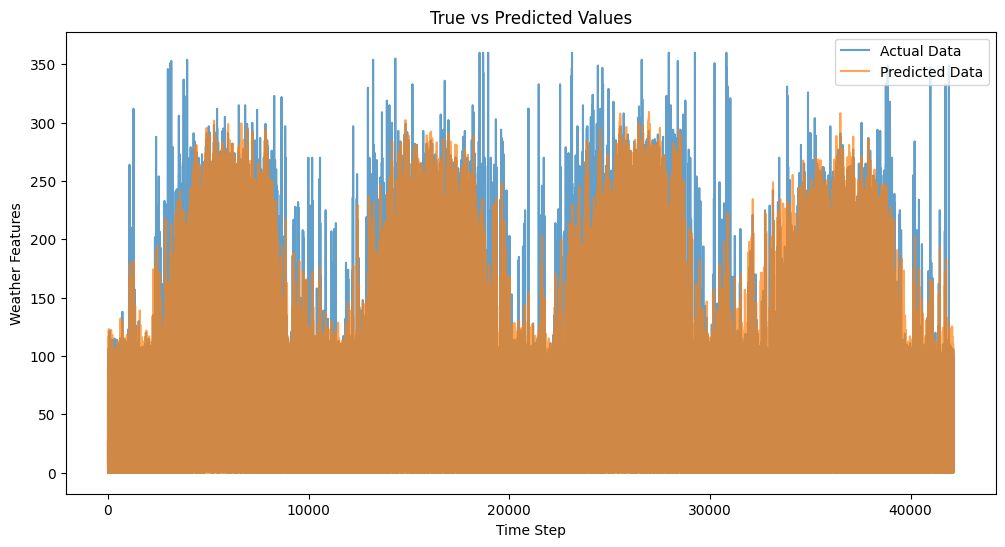

In [ ]:
import matplotlib.pyplot as plt

# Plot true vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original.flatten(), label="Actual Data", alpha=0.7)
plt.plot(y_pred_original.flatten(), label="Predicted Data", alpha=0.7)
plt.title("True vs Predicted Values")
plt.xlabel("Time Step")
plt.ylabel("Weather Features")
plt.legend()
plt.show()


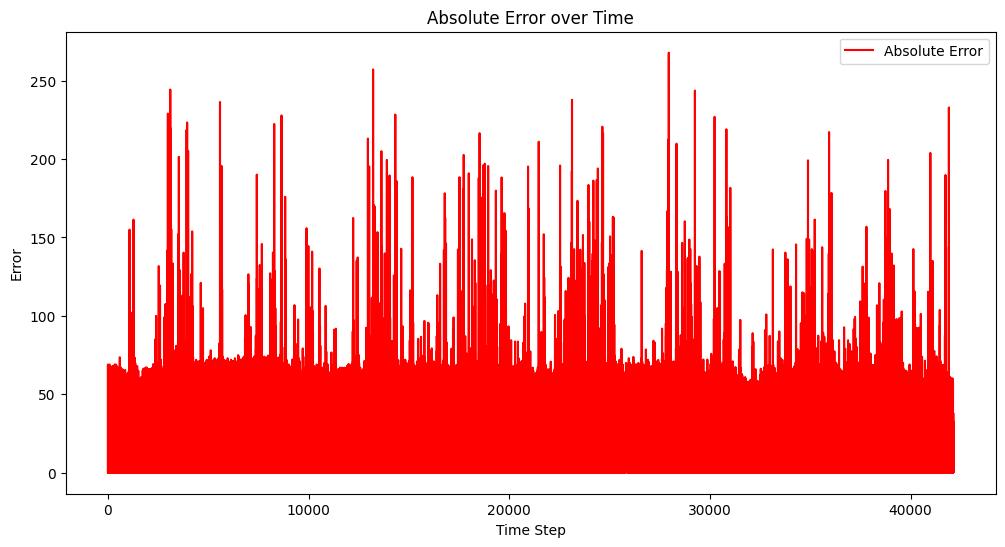

In [ ]:
# Calculate absolute error
absolute_error = np.abs(y_test_original - y_pred_original)

# Plot absolute error over time
plt.figure(figsize=(12, 6))
plt.plot(absolute_error.flatten(), label="Absolute Error", color='r')
plt.title("Absolute Error over Time")
plt.xlabel("Time Step")
plt.ylabel("Error")
plt.legend()
plt.show()


In [ ]:
# Load the saved model
model = load_model('model_lstm_weather_prediction.h5')

# Example user input weather data
user_input_weather = {
    "temperature_2m (°C)": 26.3,
    "relative_humidity_2m (%)": 91,
    "apparent_temperature (°C)": 31.5,
    "rain (mm)": 0.0,
    "cloud_cover (%)": 100,
    "wind_speed_10m (km/h)": 9.4,
    "wind_direction_10m (°)": 94
}

# Function to scale the user input
def scale_user_input(user_input, scaler, data_columns):
    input_df = pd.DataFrame([user_input])[data_columns]
    scaled_input = scaler.transform(input_df)
    return scaled_input

# Prepare the scaled input
data_columns = list(data.columns)  # Ensure column order matches dataset
scaled_user_input = scale_user_input(user_input_weather, scaler, data_columns)

# Make it a sequence (pad to match sequence length)
padded_sequence = np.zeros((seq_length, len(data_columns)))  # Initialize empty sequence
padded_sequence[-1, :] = scaled_user_input  # Add the user input at the last time step
padded_sequence = np.expand_dims(padded_sequence, axis=0)  # Reshape for LSTM input

# Predict using the model
prediction_scaled = model.predict(padded_sequence)

# Reverse scaling for the prediction
predicted_weather = scaler.inverse_transform(prediction_scaled)[0]

# Display predicted weather
predicted_result = dict(zip(data_columns, predicted_weather))
print("Predicted weather 6 hours ahead:")
print(predicted_result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicted weather 6 hours ahead:
{'temperature_2m (°C)': 26.470573, 'relative_humidity_2m (%)': 90.328835, 'apparent_temperature (°C)': 31.551533, 'rain (mm)': 0.0, 'cloud_cover (%)': 87.21225, 'wind_speed_10m (km/h)': 8.908275, 'wind_direction_10m (°)': 113.64468}


In [ ]:
# Load the saved model
model = load_model('model_lstm_weather_prediction.h5')

# Example user input weather data
user_input_weather = {
    "temperature_2m (°C)": 26.3,
    "relative_humidity_2m (%)": 91,
    "apparent_temperature (°C)": 31.5,
    "rain (mm)": 0.0,
    "cloud_cover (%)": 100,
    "wind_speed_10m (km/h)": 9.4,
    "wind_direction_10m (°)": 94
}

# Function to scale the user input
def scale_user_input(user_input, scaler, data_columns):
    input_df = pd.DataFrame([user_input])[data_columns]
    scaled_input = scaler.transform(input_df)
    return scaled_input

# Prepare the scaled input
data_columns = list(data.columns)  # Ensure column order matches dataset
scaled_user_input = scale_user_input(user_input_weather, scaler, data_columns)

# Make it a sequence (pad to match sequence length)
padded_sequence = np.zeros((seq_length, len(data_columns)))  # Initialize empty sequence
padded_sequence[-1, :] = scaled_user_input  # Add the user input at the last time step
padded_sequence = np.expand_dims(padded_sequence, axis=0)  # Reshape for LSTM input

# Predict using the model
prediction_scaled = model.predict(padded_sequence)

# Reverse scaling for the prediction
predicted_weather = scaler.inverse_transform(prediction_scaled)[0]

# Display predicted weather
predicted_result = dict(zip(data_columns, predicted_weather))
print("Predicted weather 6 hours ahead:")
print(predicted_result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
Predicted weather 6 hours ahead:
{'temperature_2m (°C)': 25.716726, 'relative_humidity_2m (%)': 25.0, 'apparent_temperature (°C)': 27.643728, 'rain (mm)': 0.0, 'cloud_cover (%)': 72.36143, 'wind_speed_10m (km/h)': 7.105435, 'wind_direction_10m (°)': 130.76617}


In [ ]:
# Load the saved model
model = load_model('model_lstm_weather_prediction.h5')

# Example user input weather data
user_input_weather = {
    "temperature_2m (°C)": 26.3,
    "relative_humidity_2m (%)": 91,
    "apparent_temperature (°C)": 31.5,
    "rain (mm)": 0.0,
    "cloud_cover (%)": 100,
    "wind_speed_10m (km/h)": 9.4,
    "wind_direction_10m (°)": 94
}

# Function to scale the user input
def scale_user_input(user_input, scaler, data_columns):
    input_df = pd.DataFrame([user_input])[data_columns]
    scaled_input = scaler.transform(input_df)
    return scaled_input

# Prepare the scaled input
data_columns = list(data.columns)  # Ensure column order matches dataset
scaled_user_input = scale_user_input(user_input_weather, scaler, data_columns)

# Make it a sequence (pad to match sequence length)
padded_sequence = np.zeros((seq_length, len(data_columns)))  # Initialize empty sequence
padded_sequence[-1, :] = scaled_user_input  # Add the user input at the last time step
padded_sequence = np.expand_dims(padded_sequence, axis=0)  # Reshape for LSTM input

# Predict using the model
prediction_scaled = model.predict(padded_sequence)

# Reverse scaling for the prediction
predicted_weather = scaler.inverse_transform(prediction_scaled)[0]

# Display predicted weather
predicted_result = dict(zip(data_columns, predicted_weather))
print("Predicted weather 6 hours ahead:")
print(predicted_result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Predicted weather 6 hours ahead:
{'temperature_2m (°C)': 26.358881, 'relative_humidity_2m (%)': 90.50981, 'apparent_temperature (°C)': 31.48213, 'rain (mm)': 1.215822, 'cloud_cover (%)': 87.23064, 'wind_speed_10m (km/h)': 9.143163, 'wind_direction_10m (°)': 109.74032}


In [ ]:
# Simpan model ke format SavedModel (protokol buffer format .pb)
model.export("saved_model_weather")

# import tensorflow as tf
# # Simpan ulang dari file .h5
# model = tf.keras.models.load_model("model_lstm_weather_prediction.h5")
# model.save("/content/saved_model_lstm")
# print("Model disimpan ulang dalam format SavedModel.")


Saved artifact at 'saved_model_weather'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  137099408416736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137099448275136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137099408188240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137099398701728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137099398702080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137099398703840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137099408424480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137099398706304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137099398825936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137099398825408: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
import tensorflow as tf

# Load the SavedModel
saved_model_dir = "saved_model_weather"

# Create the converter
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Enable resource variables for better compatibility
converter.experimental_enable_resource_variables = True

# Set the supported ops to include SELECT_TF_OPS for LSTM compatibility
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]

# Disable experimental lowering of tensor list ops
converter._experimental_lower_tensor_list_ops = False

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
with open("weather_prediction(2.0).tflite", "wb") as f:
    f.write(tflite_model)

print("Model has been converted to TFLite format and saved as 'weather_prediction.tflite'.")

Model has been converted to TFLite format and saved as 'weather_prediction.tflite'.


In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="weather_prediction(2.0).tflite")
interpreter.allocate_tensors()

# Print input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)


Input details: [{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([1, 1, 7], dtype=int32), 'shape_signature': array([-1,  1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 46, 'shape': array([1, 7], dtype=int32), 'shape_signature': array([-1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# prompt: evaluasi model gunakan rmse rms dan lain lain

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate RMS
rms = np.sqrt(np.mean(np.square(y_test_inv - y_pred_inv)))
print(f"Root Mean Square (RMS): {rms}")

# Calculate MAE
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Mean Absolute Error (MAE): {mae}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Root Mean Squared Error (RMSE): 23.720587939575214
Root Mean Square (RMS): 23.72058793957543
Mean Absolute Error (MAE): 9.966485020224724


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np

# Prediksi model
y_pred = model.predict(X_test)


# Hitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)
# Hitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Hitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error (MAE): 0.09071142674147843
Mean Squared Error (MSE): 0.01991124389513416
Root Mean Squared Error (RMSE): 0.14110720709848296
